In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid, ShuffleSplit, learning_curve, GridSearchCV

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#Decision tree
from sklearn.tree import DecisionTreeClassifier

#SMOTE
from imblearn.over_sampling import SMOTE

#Mô hình XG Boost
import xgboost as xgb

#Kiểm định Chi-squared
from scipy.stats import chi2_contingency, spearmanr, skew

import joblib

**A.Giải thích dữ liệu:**

**0.step:** Mỗi "step" đại diện cho 1 giờ trong thời gian thực. Tổng số "step" là 744, tương đương với 744 giờ, tức là 30 ngày (vì 1 ngày có 24 giờ, nên 31 ngày = 31 x 24 = 744 giờ).

**1.type:** Loại giao dịch.

"CASH-IN": Nạp tiền vào tài khoản.

"CASH-OUT": Rút tiền khỏi tài khoản.

"DEBIT": Ghi nợ từ tài khoản.

"PAYMENT": Thanh toán từ tài khoản.

"TRANSFER": Chuyển tiền từ tài khoản này sang tài khoản khác.

**2.amount:** Số tiền của giao dịch.

**3.nameOrig:** Mã định danh của tài khoản nguồn (tài khoản gửi tiền). Một chuỗi ký tự duy nhất đại diện cho tài khoản nguồn.

**4.oldbalanceOrg:** Số dư tài khoản nguồn trước khi thực hiện giao dịch.

**5.newbalanceOrig:** Số dư tài khoản nguồn sau khi thực hiện giao dịch.

**6.nameDest:** Mã định danh của tài khoản đích (tài khoản nhận tiền). Một chuỗi ký tự duy nhất đại diện cho tài khoản đích.

**7.oldbalanceDest:** Số dư tài khoản đích trước khi thực hiện giao dịch.
Đơn vị: Tiền tệ.

**8.newbalanceDest:** Số dư tài khoản đích sau khi thực hiện giao dịch.

**9.isFraud:** OUTPUT. Giao dịch có phải là gian lận hay không. 1 là giao dịch là gian lận. 0 là giao dịch không phải là gian lận.

**10.isFlaggedFraud:** Giao dịch có bị đánh dấu là gian lận bởi hệ thống phát hiện gian lận hay không. 1 là giao dịch bị hệ thống đánh dấu là gian lận. 0 là giao dịch không bị hệ thống đánh dấu là gian lận. (Không quan trọng, bỏ)

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/Synthetic_Financial_datasets_log.csv')
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
#Kiểm tra data xem là Tuyến tính hay Phi tuyến
scatter_cols = data.select_dtypes(exclude=['object']).columns
data_subset = data[scatter_cols]
# Vẽ matrix scatter plot
pair_plot = sns.pairplot(data_subset, hue='isFraud', palette={0: '#1E90FF', 1: '#B22222'})
pair_plot.fig.suptitle('Pairplot of Numerical Features with output "isFraud"', y=1.02)
plt.show()

In [22]:
num_data = data.select_dtypes(exclude=['object'])
corr = num_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


***Sampling***

*Do dữ liệu quá nhiều, nên ta sẽ lấy ra một phần của chúng để training. Ta lấy ngẫu nhiên 300.000 mẫu dữ liệu không gian lận, và tất cả 8000 dữ liệu gian lận*

In [5]:
data_fraud=data[data['isFraud']==1]

data_not_fraud = data[data['isFraud']==0]
part_of_not_fraud = data_not_fraud.sample(n=300000, random_state=42)

In [6]:
data = pd.concat([part_of_not_fraud, data_fraud])
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,468,TRANSFER,652782.54,C851249845,652782.54,0.00,C2109638287,0.00,0.00,1,0
1,142,CASH_IN,142881.01,C2060036150,4157099.97,4299980.98,C691620198,561127.28,418246.27,0,0
2,185,CASH_OUT,63613.62,C223783297,109162.00,45548.38,C1088343910,0.00,63613.62,0,0
3,36,CASH_OUT,109659.74,C1335905806,32031.57,0.00,C1467567339,505585.31,457726.46,0,0
4,181,CASH_IN,145941.95,C1230733086,22209665.18,22355607.12,C368230318,1889925.44,1743983.49,0,0
...,...,...,...,...,...,...,...,...,...,...,...
308208,232,CASH_OUT,171207.85,C1416712487,0.00,0.00,C1335737198,2916941.82,3088149.68,0,0
308209,382,CASH_OUT,182306.56,C321997692,0.00,0.00,C1837930153,240080.49,422387.05,0,0
308210,323,PAYMENT,18275.53,C1946476436,41173.00,22897.47,M348511683,0.00,0.00,0,0
308211,156,CASH_IN,31736.58,C544563579,1601699.34,1633435.92,C1853231989,104759.72,73023.14,0,0


**EDA**

In [7]:
data.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [8]:
data_fraud

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


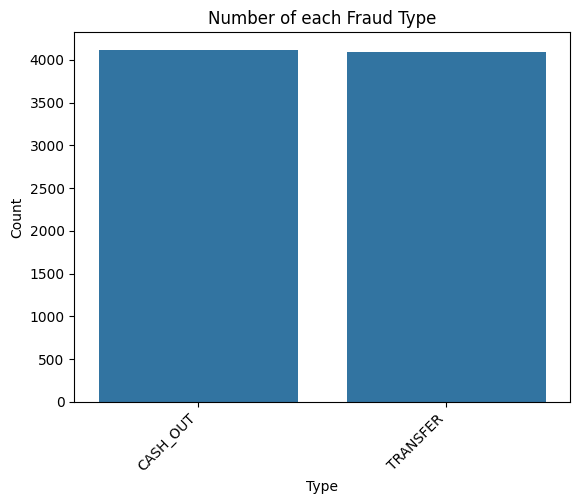

In [7]:
#Các hình thức gian lận thường là Cash_out (Rút tiền) và Transfer(Chuyển khoản)
type_counts = data_fraud['type'].value_counts()
sns.barplot(x=type_counts.index, y=type_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Number of each Fraud Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

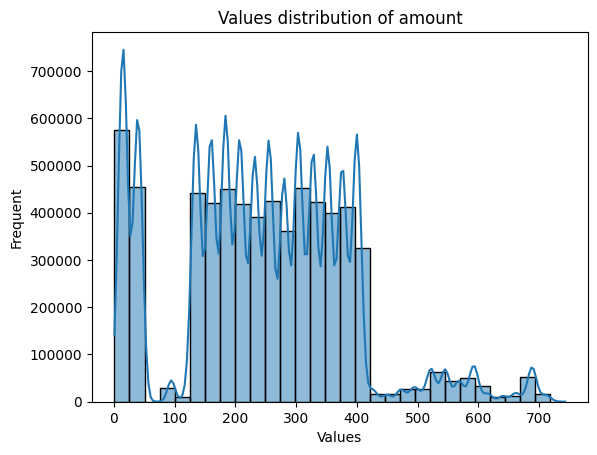

In [ ]:
#Dễ thấy: hầu hết giờ gian lận thường ở Step 0-50 và 100-tới 400, tức là khoảng từ giữa tháng đầu tiên, thời điểm hay chuyển tiền nhất
sns.histplot(data=data['step'], bins=30, kde=True)
plt.title(f'Values distribution of {j}')
plt.xlabel('Values')
plt.ylabel('Frequent')
plt.show()

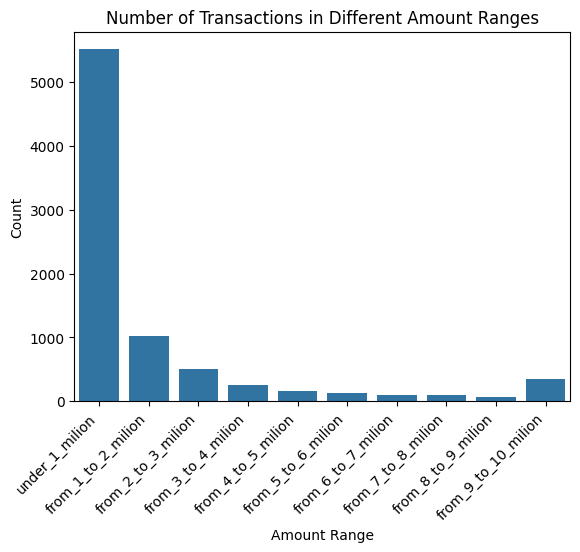

In [ ]:
#Hầu hết các giá trị lừa đảo thường dưới 1 triệu đô la
under_1_milion = []; from_1_to_2_milion = []; from_2_to_3_milion = []; from_3_to_4_milion = []; from_4_to_5_milion = [];
from_5_to_6_milion = []; from_6_to_7_milion = []; from_7_to_8_milion = []; from_8_to_9_milion = []; from_9_to_10_milion = []
for i in data_fraud['amount']:
  if 0<= i <=1000000:
    under_1_milion.append(i)
  elif 1000000 < i <= 2000000:
    from_1_to_2_milion.append(i)
  elif 2000000 < i <= 3000000:
    from_2_to_3_milion.append(i)
  elif 3000000 < i <= 4000000:
    from_3_to_4_milion.append(i)
  elif 4000000 < i <= 5000000:
    from_4_to_5_milion.append(i)
  elif 5000000 < i <= 6000000:
    from_5_to_6_milion.append(i)
  elif 6000000 < i <= 7000000:
    from_6_to_7_milion.append(i)
  elif 7000000 < i <= 8000000:
    from_7_to_8_milion.append(i)
  elif 8000000 < i <= 9000000:
    from_8_to_9_milion.append(i)
  elif 9000000 < i <= 10000000:
    from_9_to_10_milion.append(i)

amount_ranges = ['under_1_milion', 'from_1_to_2_milion', 'from_2_to_3_milion',
                 'from_3_to_4_milion', 'from_4_to_5_milion', 'from_5_to_6_milion',
                 'from_6_to_7_milion', 'from_7_to_8_milion', 'from_8_to_9_milion',
                 'from_9_to_10_milion']

amount_counts = [len(under_1_milion), len(from_1_to_2_milion), len(from_2_to_3_milion),
                 len(from_3_to_4_milion), len(from_4_to_5_milion), len(from_5_to_6_milion),
                 len(from_6_to_7_milion), len(from_7_to_8_milion), len(from_8_to_9_milion),
                 len(from_9_to_10_milion)]

# Tạo DataFrame từ danh sách để dễ dàng sử dụng với Seaborn
data_plot = pd.DataFrame({
    'Amount Range': amount_ranges,
    'Count': amount_counts
})

# Vẽ biểu đồ barplot
sns.barplot(x='Amount Range', y='Count', data=data_plot)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Transactions in Different Amount Ranges')
plt.xlabel('Amount Range')
plt.ylabel('Count')
plt.show()

**PREPROCESSING**

***Kiểm định Chi-squared***

In [9]:
obj_cols = data.select_dtypes(include=['object']).columns

#Chi-square test cho các cột Object so với cột Output của data
for i in obj_cols:
    chi2, pval, _, _ = chi2_contingency(pd.crosstab(data[i], data['isFraud']))
    print(i, '---', pval)

type --- 0.0
nameOrig --- 0.49776965358419123
nameDest --- 2.4336755831488965e-84


In [10]:
#Xóa đi 2 columns sau khi kiểm tra Chi-squared và Corr-matrix
data = data.drop(columns=['nameOrig', 'newbalanceOrig', 'newbalanceDest'])

***Kiểm định Spearman***

In [11]:
num_cols = data.select_dtypes(exclude=['object']).columns
num_df = data[num_cols]

In [12]:
correlation_results = []

# Duyệt qua tất cả các cột trong DataFrame
for col in num_df.columns:
  corr, p_value = spearmanr(num_df[col], num_df['isFraud'])  # Tính Spearman Correlation
  correlation_results.append((col, corr, p_value))

# Chuyển kết quả thành DataFrame để dễ quan sát
correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Spearman Correlation', 'p-value'])

# Hiển thị các thuộc tính có Spearman Correlation đáng kể với biến mục tiêu
print(correlation_df.sort_values(by='Spearman Correlation', ascending=False))

          Feature  Spearman Correlation        p-value
4         isFraud              1.000000   0.000000e+00
2   oldbalanceOrg              0.177029   0.000000e+00
1          amount              0.161624   0.000000e+00
0            step              0.093275   0.000000e+00
5  isFlaggedFraud              0.043547  3.035194e-129
3  oldbalanceDest             -0.077130   0.000000e+00


In [13]:
data = data.drop(columns = ['oldbalanceDest', 'isFlaggedFraud'])

***One hot coding***

In [14]:
le = LabelEncoder()
data['nameDest'] = le.fit_transform(data['nameDest'])

In [15]:
data = pd.get_dummies(data, columns=['type'], drop_first=True)

In [16]:
data

,step,amount,oldbalanceOrg,nameDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,468,652782.54,652782.54,87533,1,False,False,False,True
1,142,142881.01,4157099.97,128012,0,False,False,False,False
2,185,63613.62,109162.00,7070,0,True,False,False,False
3,36,109659.74,32031.57,36896,0,True,False,False,False
4,181,145941.95,22209665.18,102672,0,False,False,False,False
...,...,...,...,...,...,...,...,...,...
308208,232,171207.85,0.00,26496,0,True,False,False,False
308209,382,182306.56,0.00,66097,0,True,False,False,False
308210,323,18275.53,41173.00,219591,0,False,False,True,False
308211,156,31736.58,1601699.34,67282,0,False,False,False,False


**PREDICTION**

In [17]:
#Hàm đánh giá hiệu suất
def print_scores(y_test, y_pred):
  print(classification_report(y_test, y_pred))

In [18]:
#Hàm chia tập train-test và MinMax Scaler
def preprocess_data(df, test_size=0.2, random_state=42):

    # Chia tập train-test
    X = df.drop(columns=['isFraud'], axis=1)
    y = df['isFraud']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # MinMax Scaler
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [20]:
#Hàm hiển thị hiệu suất train và cross-validation
def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

***1.Random Forest***

In [19]:
X_train, X_test, y_train, y_test = preprocess_data(data)

model_RF= RandomForestClassifier(n_estimators=200, random_state=42)
model_RF.fit(X_train, y_train)

y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    239947
           1       1.00      1.00      1.00      6623

    accuracy                           1.00    246570
   macro avg       1.00      1.00      1.00    246570
weighted avg       1.00      1.00      1.00    246570

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60053
           1       0.95      0.85      0.90      1590

    accuracy                           0.99     61643
   macro avg       0.97      0.92      0.95     61643
weighted avg       0.99      0.99      0.99     61643



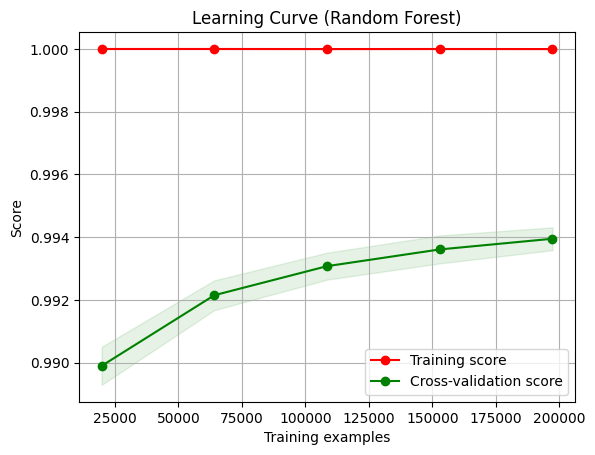

In [25]:
# Tham số của Learning Curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Vẽ biểu đồ Learning Curve (dùng X_train và y_train)
plot_learning_curve(model_RF, "Learning Curve (Random Forest)", X_train, y_train, cv=cv, n_jobs=-1)
plt.show()

***2.XGBoost***

*Có hiệu suất tốt, khi có thể loại bỏ được gần như toàn bộ các giá trị Fraud*

In [26]:
#XGBOOST
X_train, X_test, y_train, y_test = preprocess_data(data)

model_XGB = xgb.XGBClassifier(random_state=42, n_estimators = 200)
model_XGB.fit(X_train, y_train)

y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    239947
           1       0.99      0.99      0.99      6623

    accuracy                           1.00    246570
   macro avg       1.00      0.99      0.99    246570
weighted avg       1.00      1.00      1.00    246570

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60053
           1       0.96      0.94      0.95      1590

    accuracy                           1.00     61643
   macro avg       0.98      0.97      0.98     61643
weighted avg       1.00      1.00      1.00     61643



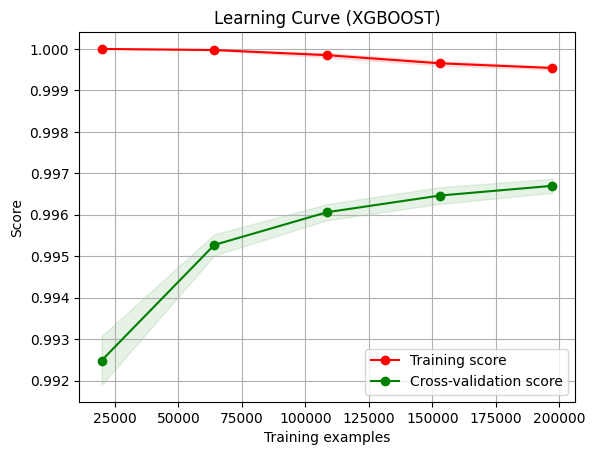

In [27]:
# Tham số của Learning Curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Vẽ biểu đồ Learning Curve (dùng X_train và y_train)
plot_learning_curve(model_XGB, "Learning Curve (XGBOOST)", X_train, y_train, cv=cv, n_jobs=-1)
plt.show()

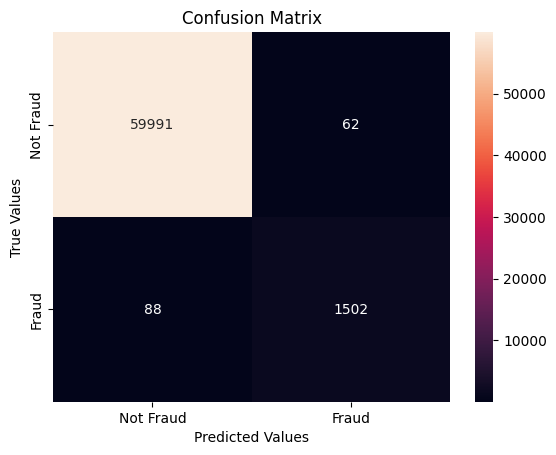

In [29]:
# Tạo confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, xticklabels=["Not Fraud", "Fraud"], yticklabels=['Not Fraud', 'Fraud'], annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

**CẢI THIỆN XGBOOST**

In [30]:
param_grid = {
  'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9],
  'learning_rate'   : [0.001, 0.01, 0.1, 1],
  'max_depth'       : [3, 5, 8, 10],
  'alpha'           : [1, 10, 100],
  'n_estimators'    : [10, 50, 100]
}

index = 0

answers_grid = {
    'combination'       :[],
    'train_Accuracy'    :[],
    'test_Accuracy'     :[],
    'colsample_bytree'  :[],
    'learning_rate'     :[],
    'max_depth'         :[],
    'alpha'             :[],
    'n_estimators'      :[]
}

In [31]:
# Tạo một lưới các tham số
param_list = list(ParameterGrid(param_grid))

X_train, X_test, y_train, y_test = preprocess_data(data)

for params in param_list:
    # Tạo mô hình với các tham số hiện tại
    model_XGB_new = xgb.XGBClassifier(
        objective='binary:logistic',  # Sử dụng mục tiêu phân loại nhị phân
        colsample_bytree=params['colsample_bytree'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        alpha=params['alpha'],
        n_estimators=params['n_estimators']
    )

    # Huấn luyện mô hình
    model_XGB_new.fit(X_train, y_train)

    # Dự đoán trên tập huấn luyện và kiểm tra
    y_train_pred = model_XGB_new.predict(X_train)
    y_test_pred = model_XGB_new.predict(X_test)

    # Tính toán độ chính xác
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Lưu trữ kết quả
    answers_grid['combination'].append(params)
    answers_grid['train_Accuracy'].append(train_accuracy)
    answers_grid['test_Accuracy'].append(test_accuracy)
    answers_grid['colsample_bytree'].append(params['colsample_bytree'])
    answers_grid['learning_rate'].append(params['learning_rate'])
    answers_grid['max_depth'].append(params['max_depth'])
    answers_grid['alpha'].append(params['alpha'])
    answers_grid['n_estimators'].append(params['n_estimators'])

# In kết quả tham số tốt nhất dựa trên độ chính xác tập kiểm tra
best_index = answers_grid['test_Accuracy'].index(max(answers_grid['test_Accuracy']))
print("Best Hyperparameters:", answers_grid['combination'][best_index])

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

Best Hyperparameters: {'alpha': 1, 'colsample_bytree': 0.7, 'learning_rate': 1, 'max_depth': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    239947
           1       0.87      0.73      0.79      6623

    accuracy                           0.99    246570
   macro avg       0.93      0.86      0.89    246570
weighted avg       0.99      0.99      0.99    246570

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     60053
           1       0.87      0.71      0.78      1590

    accuracy                           0.99     61643
   macro avg       0.93      0.85      0.89     61643
weighted avg       0.99      0.99      0.99     61643



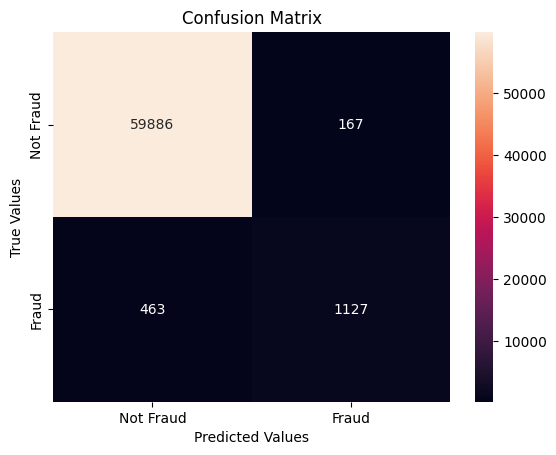

In [32]:
# Tạo confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, xticklabels=["Not Fraud", "Fraud"], yticklabels=['Not Fraud', 'Fraud'], annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

***Việc thêm các siêu tham số có vẻ không được tốt như mô hình mặc định***